In [1]:
library(ggplot2, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    col

In [2]:
# volcano plots showing all significant genes, highlighting those from different species
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("syntenous_for_deseq.collapse_species.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")

In [3]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# if this reorder doesn't work, sort excel mapping file, reload
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 106 60 
metadata(1): version
assays(1): counts
rownames(106): Actinomyces_graevenitzii_arcA
  Actinomyces_graevenitzii_arcB ... Treponema_vincentii_arcB
  Treponema_vincentii_arcC
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(12): sample_id tooth_type ... Prop_Smutans Smutans_cat

In [4]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm 
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function
norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 50 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



   user  system elapsed 
 15.653   0.769  12.529 

In [5]:
res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(res$padj < 0.05, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.05:  60"


out of 106 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 13, 12%
LFC < 0 (down)     : 47, 44%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [6]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PF_vs_PD"

In [7]:
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(resLFC$padj < 0.01, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results_ADS.collapse_species.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.01:  48"


out of 106 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 14, 13%
LFC < 0 (down)     : 51, 48%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [8]:
# transform for visualizations
vld <- varianceStabilizingTransformation(se_star)

pdf 
  2

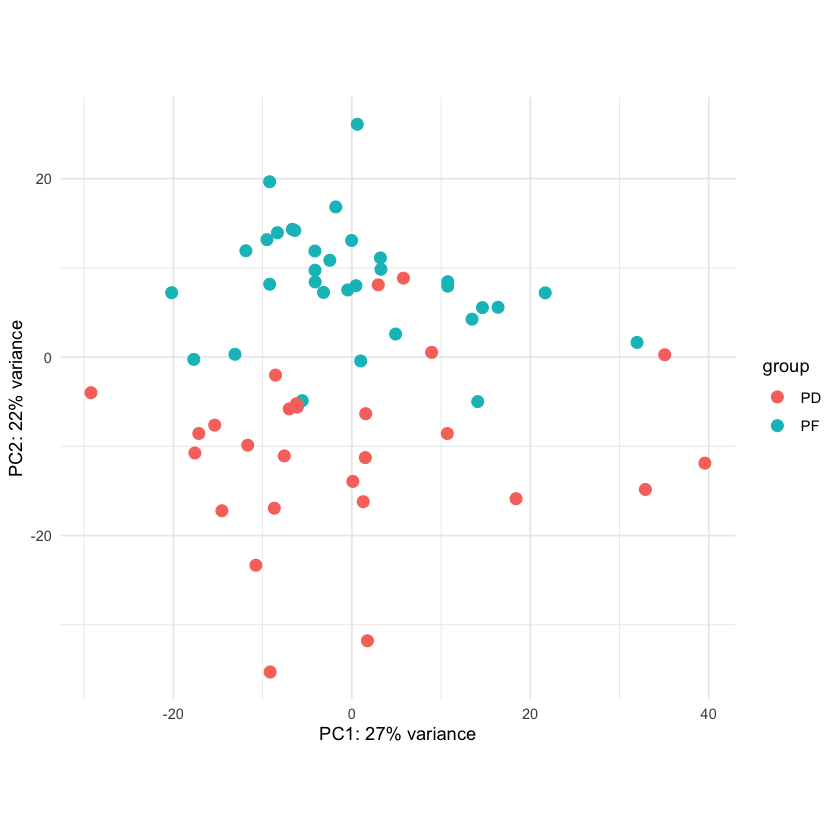

In [9]:
pdf("pca_pdvpf_ADS.collapse_species.pdf")
plotPCA(vld, intgroup=c("tooth_type")) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type")) + theme_minimal()

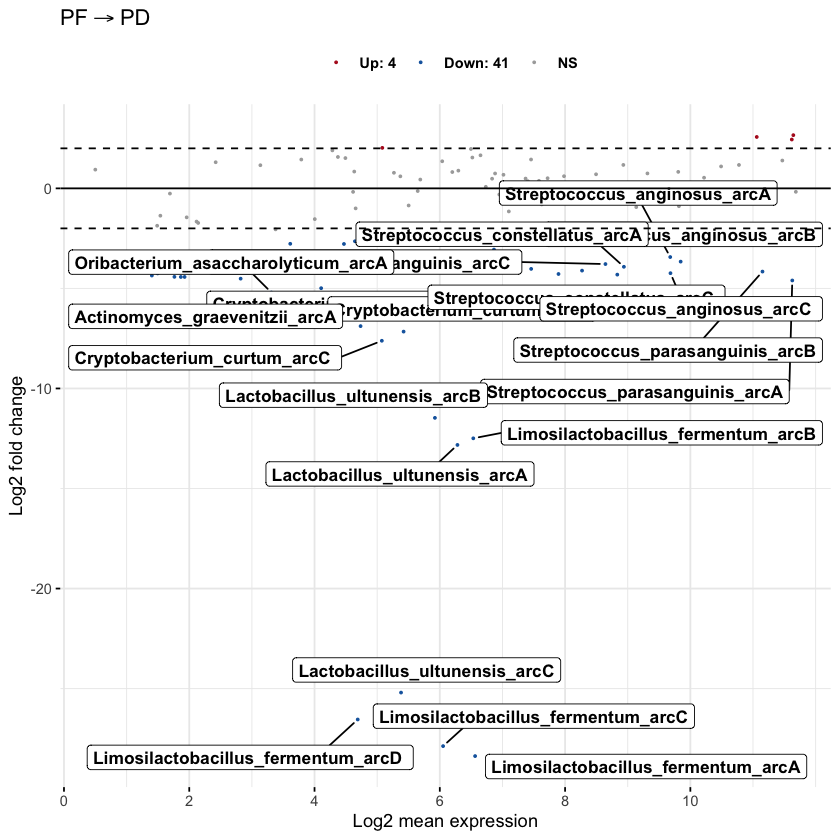

In [10]:
# install.packages("ggpubr")
library(ggpubr)
options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 20,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   ggtheme = ggplot2::theme_minimal())
p

pdf 
  2

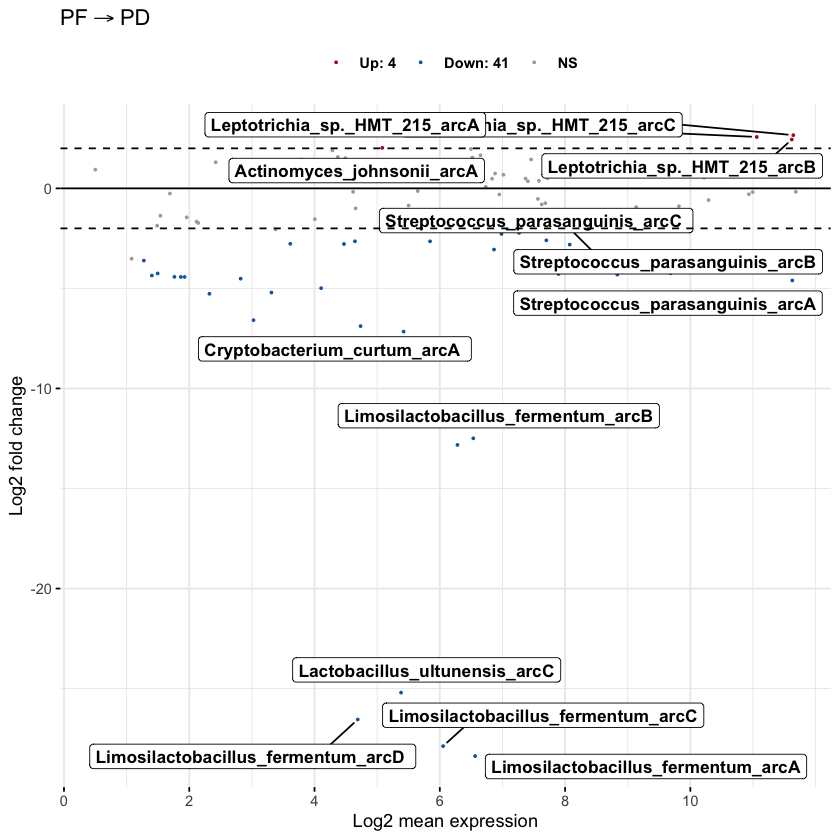

In [11]:
# get labels for top up and top down regulated genes
upreg <- res[res$log2FoldChange > 2,]
downreg <- res[res$log2FoldChange < -2,]
# rank by p value, get top 
upregname <- row.names(upreg[rank(upreg$padj) <= 9,])
# bottom 
downregname <- row.names(downreg[rank(downreg$padj) <= 9,])
regnames <- c(upregname, downregname)

options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = regnames,
   ggtheme = ggplot2::theme_minimal())
p
pdf("ads_volcano_plot.collapse_species.pdf")
p
dev.off()

In [16]:
# want to get differential abundance of taxa in PD samples with high and low S mutans
# only compare PD samples
metadata <- metadata[metadata$tooth_type == "PD",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
colnames(genecounts)
rownames(metadata)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~Smutans_cat)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("low", "high"))

[1] "UF10PD"  "UF115PD" "UF12PD"  "UF15PD"  "UF20PD"  "UF21PD"  "UF25PD" 
 [8] "UF26PD"  "UF39PD"  "UF42PD"  "UF43PD"  "UF44PD"  "UF46PD"  "UF47PD" 
[15] "UF49PDR" "UF49PD"  "UF51PD"  "UF52PDR" "UF52PD"  "UF53PDR" "UF53PD" 
[22] "UF54PD"  "UF58PD"  "UF59PD"  "UF67PDR" "UF68PD"  "UF76PDR"

[1] "UF10PD"  "UF115PD" "UF12PD"  "UF15PD"  "UF20PD"  "UF21PD"  "UF25PD" 
 [8] "UF26PD"  "UF39PD"  "UF42PD"  "UF43PD"  "UF44PD"  "UF46PD"  "UF47PD" 
[15] "UF49PDR" "UF49PD"  "UF51PD"  "UF52PDR" "UF52PD"  "UF53PDR" "UF53PD" 
[22] "UF54PD"  "UF58PD"  "UF59PD"  "UF67PDR" "UF68PD"  "UF76PDR"

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 105 27 
metadata(1): version
assays(1): counts
rownames(105): Actinomyces_graevenitzii_arcA
  Actinomyces_graevenitzii_arcB ... Treponema_vincentii_arcB
  Treponema_vincentii_arcC
rowData names(0):
colnames(27): UF10PD UF115PD ... UF68PD UF76PDR
colData names(12): sample_id tooth_type ... Prop_Smutans Smutans_cat

In [21]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm 
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function
norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(res$padj < 0.05, na.rm=TRUE))
summary(res)
# write results to file
write.table(res, file="deseq_results_ADS.smutans_lowhi_collapse_species.txt", quote=F, sep="\t")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 48 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



   user  system elapsed 
 15.015   0.535  11.412 

[1] "number of genes with adjusted p value lower than 0.05:  37"


out of 105 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 36, 34%
LFC < 0 (down)     : 1, 0.95%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [23]:
# transform for visualizations
vld <- varianceStabilizingTransformation(se_star)

pdf 
  2

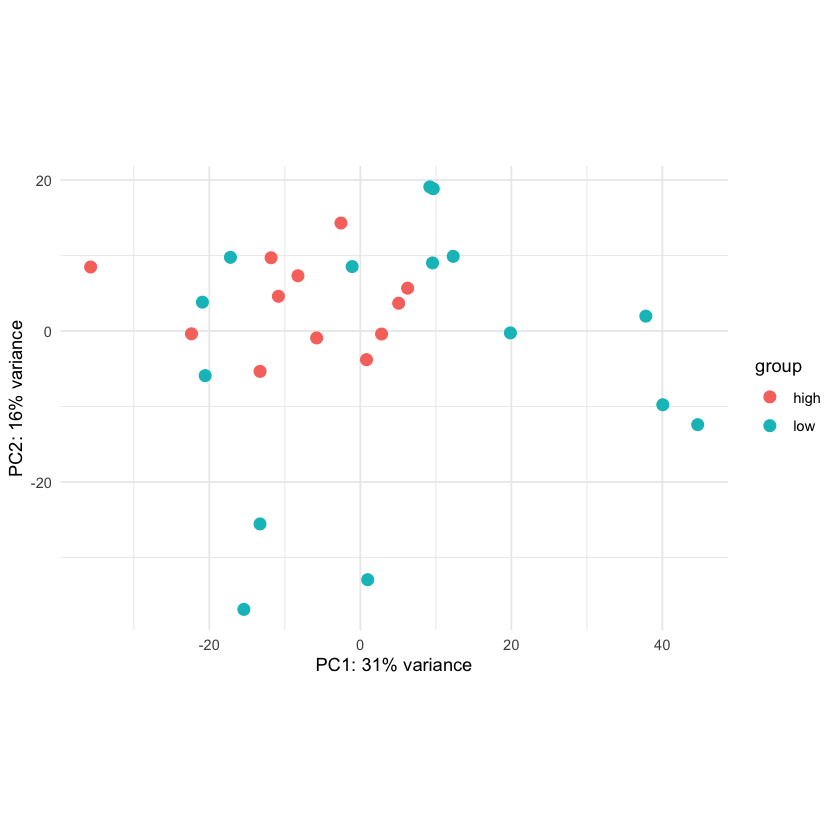

pdf 
  2

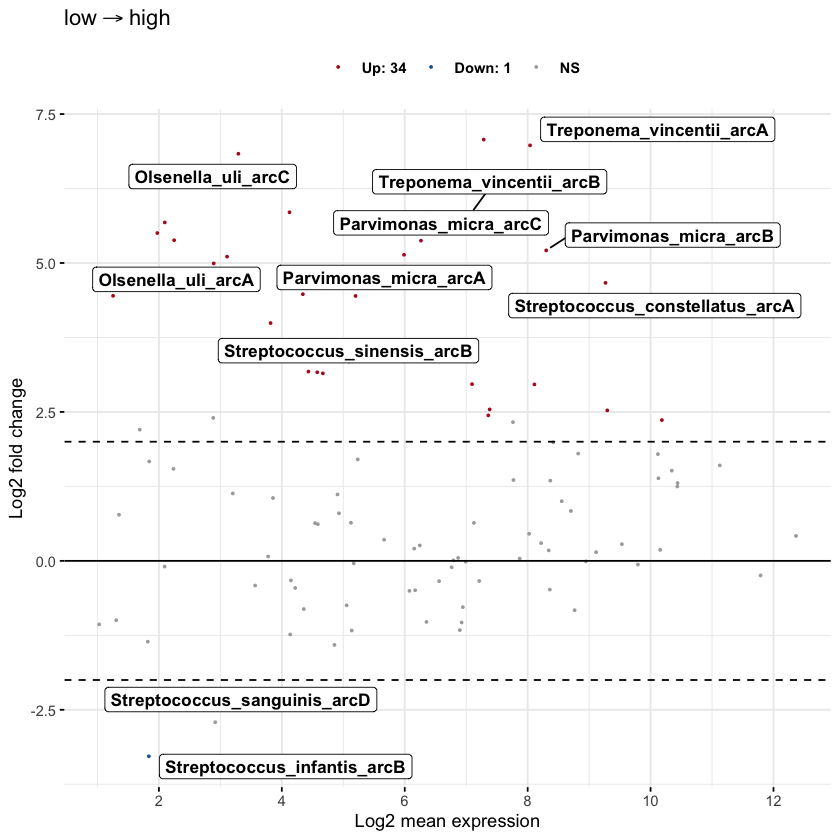

In [25]:
pdf("pca_pdvpf_ADS.smutans_lohi_collapse_species.pdf")
plotPCA(vld, intgroup=c("Smutans_cat")) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("Smutans_cat")) + theme_minimal()

# get labels for top up and top down regulated genes
upreg <- res[res$log2FoldChange > 2,]
downreg <- res[res$log2FoldChange < -2,]
# rank by p value, get top 
upregname <- row.names(upreg[rank(upreg$padj) <= 9,])
# bottom 
downregname <- row.names(downreg[rank(downreg$padj) <= 9,])
regnames <- c(upregname, downregname)

options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("low" %->% "high"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#B31B21", "#1465AC", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = regnames,
   ggtheme = ggplot2::theme_minimal())
p
pdf("volcano_plots_ADS_collapse_species.smutans_lohi.pdf")
p
dev.off()